<a href="https://colab.research.google.com/github/AgusLuigi/retail_demand_analysis/blob/main/Python_Zeitrheie_analyse_Fallstudie1_Nachfrageprognose_im_Einzelhandel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fallstudie: Nachfrageprognose im Einzelhandel

Wenn Sie wissen, wie viel von jedem Artikel morgen verkauft wird , können Sie alles Weitere planen: wie viele Einheiten Sie bestellen, welche Preisschilder Sie drucken, wie viele Mitarbeiter Sie einplanen und sogar welche LKW-Routen Sie buchen. Die Zeitreihenanalyse bietet Einzelhändlern diese Vorausschau, indem sie die Verkaufshistorie von gestern in die Bedarfsschätzung von morgen umwandelt.


- Nutzen  
  - Was es im Klartext bedeutet
- Inventar in der richtigen Größe
  - Halten Sie genügend Vorrat bereit, um die Kunden zufriedenzustellen, aber nicht so viel, dass Reste verstauben.
- Erkennen Sie die Kalenderunebenheiten
  - Beachten Sie, dass es Wochen im Voraus zu steigenden Preisen an Feiertagen, niedrigen Preisen an Wochenenden oder Spitzen zum Schulanfang kommen kann.
- Planen Sie intelligentere Werbeaktionen und Preise
  - Geben Sie Rabatte nur dann, wenn mit einem Nachfragerückgang zu rechnen ist. Vermeiden Sie unnötige Preisnachlässe, wenn sich die Artikel ohnehin verkaufen.
- Optimieren Sie die Lieferkette
  - Geben Sie Lagern und Spediteuren eine Vorwarnung, damit die Waren pünktlich eintreffen und die Lagerkosten gesenkt werden.

In [ ]:
import pandas as pd
import requests
import io

# Build the direct download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

# Dictionary of file IDs for clarity
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# Load each CSV using the helper functions
df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
# df_train          = load_csv_from_url(make_drive_url(file_ids["train"])) we dont read it as the file is too big and wont work this way
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))


In [ ]:
!pip install -q "dask[dataframe]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 44.4 MB/s eta 0:00:00


In [ ]:
import gdown

# Use our existing function to build the download URL
train_url = make_drive_url(file_ids["train"])

# Download the file using gdown
gdown.download(train_url, "train.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=7ac66abe-f7e1-46a9-9fb4-6f32d60baff7
To: /content/train.csv
100%|██████████| 5.00G/5.00G [01:19<00:00, 63.1MB/s]


'train.csv'

In [ ]:
store_ids = df_stores[df_stores['state'] == 'Pichincha']['store_nbr'].unique()

In [ ]:
import pandas as pd

chunk_size = 10**6  # 1 million rows at a time
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size):
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    filtered_chunks.append(chunk_filtered)
    del chunk  # Free up memory

In [ ]:
df_train = pd.concat(filtered_chunks, ignore_index=True)
df_train = df_train.sample(n=2_000_000).reset_index(drop=True)
del filtered_chunks
# Loads first 5 rows
df_train.head(5)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,733739,2013-01-20,6,870546,8.0,NaN
1,5195728,2013-05-05,47,410257,139.0,NaN
2,47749079,2015-05-30,4,1159413,8.0,False
3,83229613,2016-06-26,20,1958177,6.0,False
4,117675057,2017-06-02,47,1914278,1.0,False


# EDA-Schritt 1: Auf fehlende Daten prüfen

In [ ]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,360104


In [ ]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

/tmp/ipython-input-2380528398.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


In [ ]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0


In [ ]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,733739,2013-01-20,6,870546,8.0,False
1,5195728,2013-05-05,47,410257,139.0,False
2,47749079,2015-05-30,4,1159413,8.0,False
3,83229613,2016-06-26,20,1958177,6.0,False
4,117675057,2017-06-02,47,1914278,1.0,False


# EDA-Schritt 2: Umgang mit Ausreißern

In [ ]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
11927,86476910,2016-07-30,7,1348510,-1.000,False
13921,58145762,2015-10-02,45,930247,-1.000,False
25356,112289722,2017-04-13,7,1465644,-1.000,False
27535,110504263,2017-03-27,3,1695837,-2.264,False
35104,49022943,2015-06-15,8,346066,-4.000,False


In [ ]:
# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

In [ ]:
# Checking negative sales got correctly replaced
df_train[df_train['unit_sales'] < 0]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion


## Extrem hohe Umsätze

In [ ]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score for unit_sales (avoiding division by zero for standard deviation), and store it in a new column called z_score
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

# Apply the Z-score calculation to each store-item group, then flatten the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 2048


/tmp/ipython-input-1143551146.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
1535,15336396,2013-12-12,1,115894,306.0,False,7.171694
2641,100931171,2016-12-24,1,153267,34.0,False,5.329395
3237,73456580,2016-03-16,1,158956,52.0,False,6.943399
3671,6840944,2013-06-12,1,165550,46.0,False,5.592039
4575,72307769,2016-03-04,1,173113,13.0,False,5.491080


Berechnen Sie einen Z-Score innerhalb dieser kleinen Historie

# EDA- Schritt 3: Fehlende Daten mit Nullverkäufen füllen

 - Konsistenz in Zeitschritten
 - Genaue Darstellung von Verkaufsmustern
 - Vermeidung von Datenfehlausrichtungen
 - Bessere Modellgenauigkeit

Wandeln Sie die dateSpalte in echte Daten um

In [ ]:
# Make sure the date column is a real datetime
df_train['date'] = pd.to_datetime(df_train['date'])

Schreiben Sie eine Funktion, um für jedes Laden-Artikel-Paar einen vollständigen Tageskalender zu erstellen.

In [ ]:
import pandas as pd

def fill_calendar(group):
    """
    Füllt die Zeitreihe für ein einzelnes (store_nbr, item_nbr)-Paar auf,
    indem fehlende Tage im Datumsbereich mit 0 für 'unit_sales' ergänzt werden.

    group enthält alle Zeilen für EIN (store_nbr, item_nbr) Paar.
    """
    # 1. Datum als Index setzen und nach Datum sortieren
    # Dies ist notwendig für die Resampling-Funktion asfreq().
    g = group.set_index("date").sort_index()

    # 2. Resampling auf tägliche Frequenz ('D') und fehlende Werte mit 0 auffüllen
    # Dies ist der zentrale Schritt, der alle fehlenden Tage hinzufügt.
    g = g.asfreq("D", fill_value=0)

    # 3. Die Bezeichner (store_nbr, item_nbr) wieder hinzufügen
    # Die asfreq-Operation kann diese Spalten fallen lassen;
    # da sie innerhalb der Gruppe konstant sind, nehmen wir einfach den ersten Wert.
    g["store_nbr"] = group["store_nbr"].iloc[0]
    g["item_nbr"]  = group["item_nbr"].iloc[0]

    # 4. Den Datumsindex zurück in eine normale Spalte umwandeln und zurückgeben
    return g.reset_index()

# ANWENDUNG DES MUSTERS AUF DEN GESAMTEN DATAFRAME:
# Diese Operation dauert einige Zeit, da sie jede Kombination aus
# Geschäft und Artikel einzeln verarbeitet (Gruppierung).


Wenden Sie die Hilfsfunktion auf jedes Geschäft-Artikel-Paar an

In [ ]:
df_train = (
    df_train
    .groupby(["store_nbr", "item_nbr"], group_keys=False)  # keeps memory low
    .apply(fill_calendar)
)

/tmp/ipython-input-1191857923.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_calendar)


Ergebnis

In [ ]:
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-01-11,362634,1,96995,1.0,False
1,2013-01-12,0,1,96995,0.0,0
2,2013-01-13,0,1,96995,0.0,0
3,2013-01-14,0,1,96995,0.0,0
4,2013-01-15,0,1,96995,0.0,0


In [ ]:
# Make sure the date column is a real datetime
df_train['date'] = pd.to_datetime(df_train['date'])

def fill_calendar(group):
    #
    # group contains all rows for ONE (store_nbr, item_nbr) pair
    #
    g = group.set_index("date").sort_index()   # use calendar as the index
    g = g.asfreq("D", fill_value=0)            # make it daily; add 0 where missing

    # put the identifiers back (asfreq drops them)
    g["store_nbr"] = group["store_nbr"].iloc[0]
    g["item_nbr"]  = group["item_nbr"].iloc[0]

    return g.reset_index()                     # date back to a normal column

df_train = (
    df_train
    .groupby(["store_nbr", "item_nbr"], group_keys=False)  # keeps memory low
    .apply(fill_calendar)
)

df_train.head()

/tmp/ipython-input-554488917.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_calendar)


,date,id,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-01-11,362634,1,96995,1.0,False
1,2013-01-12,0,1,96995,0.0,0
2,2013-01-13,0,1,96995,0.0,0
3,2013-01-14,0,1,96995,0.0,0
4,2013-01-15,0,1,96995,0.0,0


# EDA- Schritt 4: Feature Engineering: Ein Datum in nützliche Signale umwandeln

Jahr, Monat, Tag, Wochentag


In [ ]:
# Make sure 'date' is a real datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Split the timestamp into model-friendly parts
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek # Monday=0 … Sunday=6

# Lets check the result
df_train.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week
0,2013-01-11,362634,1,96995,1.0,False,2013,1,11,4
1,2013-01-12,0,1,96995,0.0,0,2013,1,12,5
2,2013-01-13,0,1,96995,0.0,0,2013,1,13,6
3,2013-01-14,0,1,96995,0.0,0,2013,1,14,0
4,2013-01-15,0,1,96995,0.0,0,2013,1,15,1


Gleitende Durchschnitte


In [ ]:
# 7-day rolling average of unit_sales, per (item, store)
df_train = df_train.sort_values(["item_nbr", "store_nbr", "date"]).reset_index(drop=True) # make sure rows are in time order

df_train["unit_sales_7d_avg"] = (
    df_train
    .groupby(["item_nbr", "store_nbr"])["unit_sales"]      # isolate one time-series per (item, store), get the units sold
    .transform(lambda s: s.rolling(window=7, min_periods=1).mean())       #  mean of last 7 days, i.e. 7-day moving average, aligned back to original df
)

In [ ]:
# Lets see how the new column unit_sales_7d_avg looks like. For that, we'll need to select a store and item.
# Get store and item from the first row
store_id = df_train.iloc[0]['store_nbr']
item_id = df_train.iloc[0]['item_nbr']

# Filter the DataFrame for this store-item pair
sample = df_train[(df_train['store_nbr'] == store_id) & (df_train['item_nbr'] == item_id)]
sample.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,2013-01-11,362634,1,96995,1.0,False,2013,1,11,4,1.000000
1,2013-01-12,0,1,96995,0.0,0,2013,1,12,5,0.500000
2,2013-01-13,0,1,96995,0.0,0,2013,1,13,6,0.333333
3,2013-01-14,0,1,96995,0.0,0,2013,1,14,0,0.250000
4,2013-01-15,0,1,96995,0.0,0,2013,1,15,1,0.200000


 Tipp für Studenten: Sie können auch verschiedene Store-Item-Paare erkunden, indem Sie iloc[0]zu iloc[1], iloc[10], usw. wechseln oder eine zufällige Zeile auswählen

In [ ]:
random_row = df_train.sample(1).iloc[0]
store_id = random_row['store_nbr']
item_id = random_row['item_nbr']
print (item_id)
print (store_ids)

1967150
[ 1  2  3  4  6  7  8  9 10 11 17 18 20 44 45 46 47 48 49]


# Save stand

In [ ]:
import pandas as pd
import os
from google.colab import drive

# 1. Mount Drive (einmaliger Klick zur Autorisierung)
drive.mount('/content/drive')

# --- Variablen definieren ---
# Das Verzeichnis, in dem die Datei gespeichert werden soll
FOLDER_PATH = "/content/drive/MyDrive/time_series_course"
# Der vollständige Pfad zur Datei
FILE_NAME = "df_train_clean.pkl"
save_path = os.path.join(FOLDER_PATH, FILE_NAME)

# 2. ÜBERPRÜFEN und ERSTELLEN des Ordners
# Die Funktion os.makedirs erstellt das Verzeichnis, falls es nicht existiert.
# Das Argument exist_ok=True verhindert einen Fehler, falls der Ordner bereits da ist.
try:
    os.makedirs(FOLDER_PATH, exist_ok=True)
    print(f"Zielordner existiert oder wurde erstellt: {FOLDER_PATH}")
except Exception as e:
    print(f"Fehler beim Erstellen des Ordners: {e}")
    # Beenden Sie hier, wenn der Ordner nicht erstellt werden konnte.

# 3. SPEICHERN des bereinigten DataFrames
# Dies funktioniert nun, da das Zielverzeichnis garantiert existiert.
df_train.to_pickle(save_path)

print(f"DataFrame erfolgreich gespeichert unter: {save_path}")

# -----------------------------------------------
# Nächstes Mal, wenn Sie das Notebook erneut öffnen (Laden)
# -----------------------------------------------

# load_path = save_path # Verwenden Sie denselben Pfad zum Laden
# df_train = pd.read_pickle(load_path)
# print("DataFrame neu geladen, bereit zum Arbeiten!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Zielordner existiert oder wurde erstellt: /content/drive/MyDrive/time_series_course
DataFrame erfolgreich gespeichert unter: /content/drive/MyDrive/time_series_course/df_train_clean.pkl


# EDA- Schritt 5: Visualisierung von Zeitreihendaten

a) Umsatz im Zeitverlauf (aggregiert)
- Gruppieren Sie die Daten nach Datum , sodass wir eine Zeile pro Tag erhalten.
- Fassen Sie dieunit_sales Ergebnisse für jeden Tag für alle Geschäfte und Produkte zusammen.

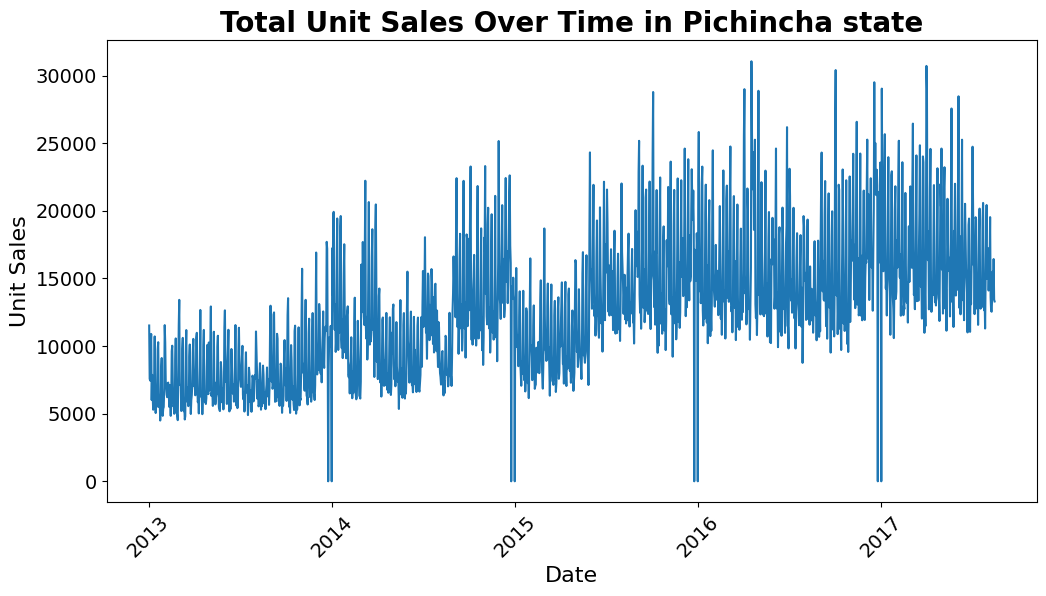

In [ ]:
import matplotlib.pyplot as plt

# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Pichincha state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

- Welche Trends stellen Sie im Laufe der Zeit fest?
- Gibt es wiederkehrende Muster?
- Was ist mit den plötzlichen Einbrüchen? Warum können die Umsätze an diesen Tagen auf Null sinken?

- Gesamtwachstumstrend
Es gibt einen klaren Aufwärtstrend beim täglichen Gesamtumsatz über die Jahre hinweg:
Im Jahr 2013 schwanken die meisten Verkäufe zwischen 5.000 und 12.000 Einheiten pro Tag.
In den Jahren 2016–2017 überstiegen die Spitzenverkäufe regelmäßig 25.000–30.000 Einheiten.
Dies deutet darauf hin, dass das Geschäft expandiert ist – vielleicht wurden mehr Geschäfte eröffnet, die Produktvielfalt hat zugenommen oder die Kundennachfrage ist deutlich gestiegen.

- Wiederkehrende starke Einbrüche
Sie werden plötzliche Abfälle auf nahezu Null bemerken , die etwa einmal im Jahr auftreten:
Dabei handelt es sich wahrscheinlich um betriebsfreie Tage wie Neujahr , Weihnachten oder Wahltage , an denen alle oder die meisten Geschäfte geschlossen sind.
Da diese Ereignisse jedes Jahr gleich sind, sollten sie in die Prognosen einbezogen werden, um verzerrte Vorhersagen zu vermeiden.

- Wöchentliche und saisonale Muster
Obwohl das Diagramm etwas dicht ist, können Sie kurzfristige Schwankungen erkennen – Spitzen und Tiefs treten häufig auf:
Diese spiegeln wahrscheinlich wöchentliche Zyklen wider (z. B. Wochenenden oder Werbeaktionen).
Sie werden auch saisonale Wellen sehen – größere Anstiege gegen Ende jedes Jahres, die mit Feiertagen und Festen einhergehen.

- Geschäftserkenntnisse:
Planen Sie jährliche Spitzen ein – insbesondere das vierte Quartal – um Lagerbestände und Personaleinsatz zu optimieren.
Vergessen Sie nicht die Einbrüche – diese müssen in Feiertagskalender und Prognosetools integriert werden, um Überschätzungen zu vermeiden.
Das Wachstum der täglichen Verkäufe weist eine positive Entwicklung auf – Daten können dabei helfen, die Gründe für diesen Erfolg aufzudecken.

b) Umsatzentwicklung nach Jahr und Monat


Schritt 1: Aggregieren Sie den Umsatz nach Jahr und Monat

Schritt 2: Erstellen Sie eine Heatmap der Verkäufe nach Jahr und Monat

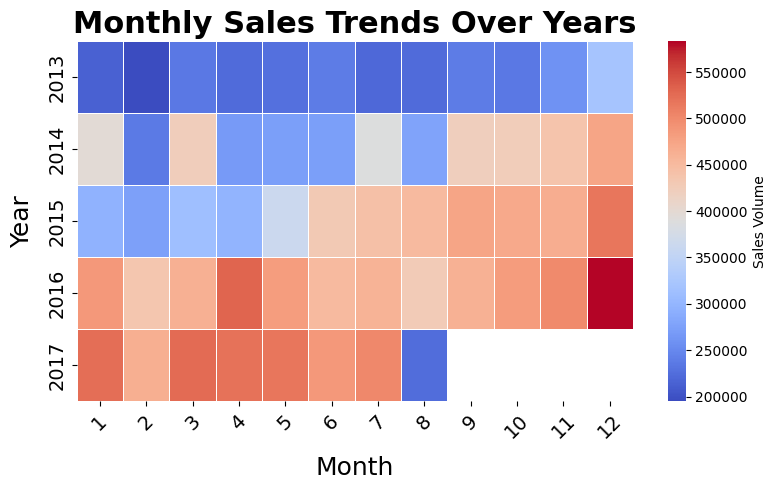

In [ ]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()
# Plotting heatmap of sales by year and month
import seaborn as sns

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility

sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

- In welchen Monaten scheinen die Umsätze durchweg höher oder niedriger zu sein?
- Können Sie im Vergleich zum Vorjahr irgendwelche Trends erkennen ?
- Gibt es saisonale Muster ?
- Was ist Ihrer Meinung nach im August 2017 passiert ?

- Klare saisonale Muster
Der Dezember ist fast jedes Jahr der umsatzstärkste Monat . Das ist verständlich, denn im Dezember fallen wichtige Feiertage wie Weihnachten, die zu hohen Verbraucherausgaben führen.
Auch in der zweiten Jahreshälfte (September–November) steigen die Umsätze tendenziell stetig an, was auf eine starke Nachfrage vor den Feiertagen hindeutet.

- Langsame Monate
In den ersten Monaten des Jahres (Januar bis März) sind die Umsätze normalerweise geringer. Dies ist im Einzelhandel üblich – nach der Weihnachtszeit neigen die Menschen dazu, ihre Ausgaben zu reduzieren.
In einigen Monaten zur Jahresmitte (wie etwa im August 2017) kann es zu unerwarteten Rückgängen kommen, möglicherweise aufgrund von Datenlücken oder Störungen (z. B. fehlende Daten, Ladenschließungen, Streiks oder Bestandsproblemen).

- Wachstum im Jahresvergleich
Wir sehen auch einen Aufwärtstrend über die Jahre hinweg – 2016 und 2017 sind im Allgemeinen wärmer (roter), was auf höhere Gesamtverkäufe im Vergleich zu 2013–2014 hindeutet. Dies könnte folgende Auswirkungen haben:
Geschäftserweiterung (mehr Geschäfte, mehr Produkte),
Erhöhte Kundennachfrage,
Bessere Werbeaktionen oder Preisstrategien.

- Was ist im August 2017 passiert?
Der August 2017 ist ein deutlicher Ausreißer (dunkelblau) und weist im Vergleich zu den umliegenden Monaten ungewöhnlich niedrige Umsätze auf . Dies könnte folgende Gründe haben:
Unvollständige Daten für diesen Monat (wir sehen, dass dies der letzte Monat in unserem Datensatz ist, vielleicht sind es nur die ersten Tage im August und dann wurden keine Daten mehr erfasst)
Eine Störung wie ein Problem in der Lieferkette,
Nationale oder regionale Ereignisse, die den Einzelhandel betreffen.

# Geschäftserkenntnisse:
- Planen Sie Großes für das vierte Quartal (insbesondere Dezember) – erhöhen Sie Lagerbestände, Personal und Werbeaktionen.
- Nutzen Sie ruhigere Monate (Q1), um Lagerbestände abzubauen oder Änderungen zu testen, wenn die Nachfrage gering ist.
- Untersuchen Sie Anomalien wie im August 2017, um sicherzustellen, dass die Prognosemodelle weiterhin genau und die Daten sauber sind.

# EDA- Schritt 6: Untersuchung der Auswirkungen von Feiertagen

1. Werfen Sie einen Blick in die Urlaubsdatei

In [ ]:
df_holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


2. Konvertieren Sie datein eine echte Datums- und Uhrzeitangabe und überprüfen Sie den Bereich

In [ ]:
# Convert date column to datetime
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])
print(
    "Holiday file covers:",
    df_holiday_events['date'].dt.date.min(), "→",
    df_holiday_events['date'].dt.date.max()
)

Holiday file covers: 2012-03-02 → 2017-12-26


3. Fügen Sie Feiertage zu unserem Verkaufstisch hinzu

In [ ]:
df_train_holiday = pd.merge(
    df_train,                     # daily sales
    df_holiday_events[['date', 'type']],  # keep only what we need
    on='date',
    how='left'                    # non-holiday days get NaN in 'type'
)
df_train_holiday.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,type
0,2013-01-11,362634,1,96995,1.0,False,2013,1,11,4,1.000000,NaN
1,2013-01-12,0,1,96995,0.0,0,2013,1,12,5,0.500000,Work Day
2,2013-01-13,0,1,96995,0.0,0,2013,1,13,6,0.333333,NaN
3,2013-01-14,0,1,96995,0.0,0,2013,1,14,0,0.250000,NaN
4,2013-01-15,0,1,96995,0.0,0,2013,1,15,1,0.200000,NaN


## Wie viele Einheiten werden an einem durchschnittlichen Feiertag im Vergleich zu einem normalen Arbeitstag verkauft?“

4. Vergleichen Sie den durchschnittlichen Umsatz für jeden Feiertagstyp
- Gruppieren Sie nach der typeSpalte, die wir gerade hinzugefügt haben.
- Nehmen Sie den Mittelwert in unit_salesjeder Gruppe.
- Stellen Sie das Ergebnis als einfaches Balkendiagramm dar.
Code
in die Zwischenablage kopiert
12345678910


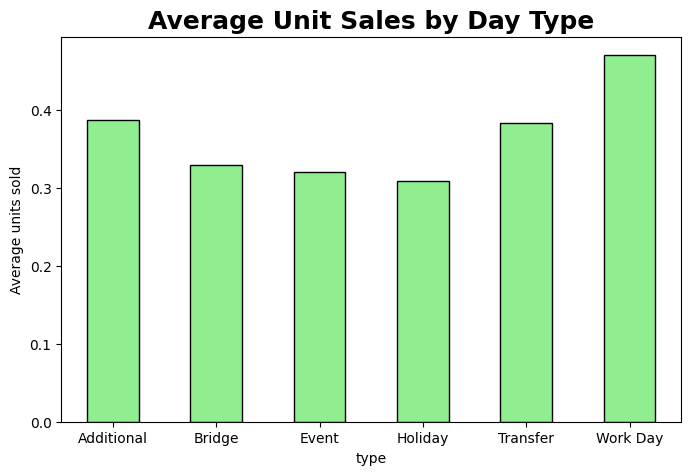

In [ ]:
# 4. Compare average sales for each holiday type
# 1–2  average units sold for each day-type
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# 3  bar chart
holiday_sales.plot(kind='bar', figsize=(8,5), color='lightgreen', edgecolor='black')
plt.title('Average Unit Sales by Day Type', fontsize=18, weight='bold')
plt.ylabel('Average units sold')
plt.xticks(rotation=0)
plt.show()

- Welche Tagestypen weisen die höchsten und niedrigsten Durchschnittsumsätze auf?
- Welche Muster fallen Ihnen auf?
- Was könnte der Grund für diese Unterschiede sein?

- Planen Sie hohe Umsätze an Werktagen und zusätzlichen Tagen ein (wie Sie es für einen Samstag tun würden).
- Überwachen Sie die Transfertage genau – sie können wertvoll sein, sind aber schwieriger vorherzusagen.
- Seien Sie an echten Feiertagen und bei besonderen Ereignissen vorsichtig , da diese zu weniger Kundenverkehr und Umsatz führen können.

# Schritt 7: Verderbliche Artikel analysieren

1. Werfen Sie einen Blick auf die Artikeldatei


In [ ]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


2. Fügen Sie unserer Trainingstabelle die Flagge „verderblich“ hinzu

In [ ]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
df_train_items.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,family,class,perishable
0,2013-01-11,362634,1,96995,1.0,False,2013,1,11,4,1.000000,GROCERY I,1093,False
1,2013-01-12,0,1,96995,0.0,0,2013,1,12,5,0.500000,GROCERY I,1093,False
2,2013-01-13,0,1,96995,0.0,0,2013,1,13,6,0.333333,GROCERY I,1093,False
3,2013-01-14,0,1,96995,0.0,0,2013,1,14,0,0.250000,GROCERY I,1093,False
4,2013-01-15,0,1,96995,0.0,0,2013,1,15,1,0.200000,GROCERY I,1093,False


3. Vergleichen Sie den Gesamtumsatz für verderbliche und nicht verderbliche Waren

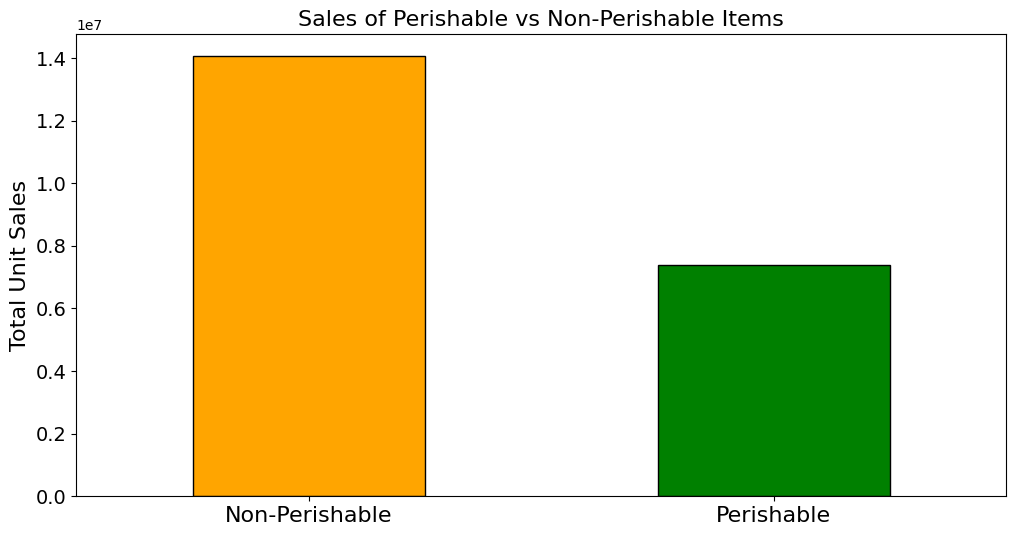

In [ ]:
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(12,6))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()

- Welche Kategorie – verderbliche oder nicht verderbliche Waren – verzeichnet das größere Gesamtumsatzvolumen?
- Welchen Anteil am Gesamtumsatz stellt jeder Balken ungefähr dar?
- Warum könnten verderbliche Waren im Gesamtumsatz hinter haltbaren Waren zurückbleiben (oder vor ihnen liegen)?
- Wie könnten sich diese Anteile auf Bestandsentscheidungen und Abfall auswirken?

- Mit rund 14 Millionen verkauften Einheiten dominieren haltbare Lebensmittel , was etwa 65 % des Gesamtvolumens entspricht.
  - Dabei handelt es sich um haltbare Artikel (Konserven, Snacks, Reinigungsprodukte), die Geschäfte in großen Mengen kaufen und ohne Risiko länger aufbewahren können.
- Die restlichen ca. 35 % – also etwa 7 Millionen Einheiten – entfallen auf verderbliche Waren .
  - Hierzu zählen frische Produkte, Fleisch, Milchprodukte und Backwaren, die schnell verderben, wenn sie nicht verkauft werden.

## Praktische Erkenntnisse
- Bei verderblichen Waren ist die Prognosegenauigkeit von größter Bedeutung. Schon ein kleiner Fehler kann zu Kosten durch Verderb oder leeren Regalen führen.
- Lieferrhythmus optimieren. Täglich frische Lieferungen, wöchentliche Trockenwarenauffüllung.
- Nutzen Sie margenfreundliche Taktiken für verderbliche Waren. Reduzieren Sie den Preis kurz vor dem Ablaufdatum und bündeln Sie frische Artikel mit haltbaren Waren mit hohen Margen.
- Planen Sie Regalfläche sinnvoll ein. Haltbare Waren steigern das Volumen, verderbliche Waren fördern das Frischegefühl und die Kundentreue.

# Schritt 8: Analyse der Auswirkungen der Ölpreise

Übung: Bewegen sich die Ölpreise zusammen mit unseren Umsätzen?

- df_train – bereinigte Tagesumsätze (mit date, unit_sales, etc.)
- df_oil – tägliche WTI-Ölpreise ( date, dcoilwtico)

- Erwartete Ausgabe
1. Ein Diagramm, in dem Sie beide Zeitreihen zusammen sehen können.
2. Eine kurze Anmerkung: Erkennen Sie einen offensichtlichen Zusammenhang? Z. B. „Keine offensichtliche Korrelation“ oder „Beide Reihen gehen Anfang 2016 zurück, was darauf hindeutet …“).

- Führen Sie die beiden DataFrames in der dateSpalte zusammen. Wir verwenden pd.merge(..., how='left'), damit jeder Verkaufstag seine Zeile behält, auch wenn die Ölreihe Lücken aufweist.
- Erstellen Sie ein Diagramm mit zwei Achsen (Ölpreis auf der einen Y-Achse, Absatz auf der anderen), um beide Zeitreihen im Zeitverlauf zu visualisieren. Wie bereits zuvor ermöglicht plt.subplots()+ ax.twinx()die Darstellung zweier Y-Achsen in derselben Abbildung. Wir beschriften jede Achse deutlich ( Oil Price, Unit Sales) und fügen einen Titel hinzu.
- Interpret : Bemerken Sie Zeiträume, in denen Ölpreisspitzen oder -rückgänge mit Umsatzänderungen einherzugehen scheinen?

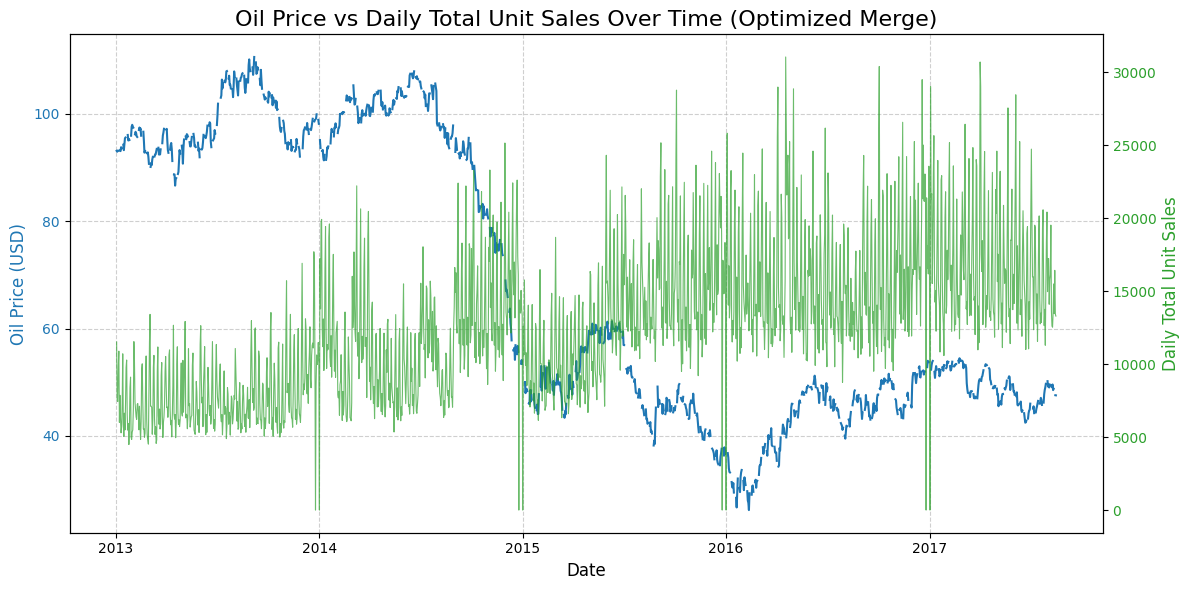

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# FIX: Behebt den OverflowError beim Plotten großer Datensätze.
plt.rcParams['agg.path.chunksize'] = 20000

# 1. Datenvorbereitung
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_train['date'] = pd.to_datetime(df_train['date'])

# --- OPTIMIERUNG FÜR SPEICHEREFFIZIENZ (NEU) ---
# Zuerst den Gesamtumsatz pro Tag berechnen (Aggregation VOR dem Merge).
# Dies reduziert die Größe des DataFrames drastisch.
df_train_daily_sum = df_train.groupby('date')['unit_sales'].sum().reset_index()

# 2. Merging (Jetzt nur auf ca. 1700 Zeilen statt Millionen)
df_merged_daily = pd.merge(
    df_train_daily_sum,
    df_oil[['date', 'dcoilwtico']],
    on='date',
    how='left'
)

# 3. Plotting (Zwei Achsen)
fig, ax1 = plt.subplots(figsize=(12,6))

# Achse 1: Ölpreis (dcoilwtico)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Oil Price (USD)', color='tab:blue', fontsize=12)
ax1.plot(df_merged_daily['date'], df_merged_daily['dcoilwtico'], color='tab:blue', label='Oil Price', linewidth=1.5)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# Achse 2: Unit Sales (zweite Y-Achse)
ax2 = ax1.twinx()
ax2.set_ylabel('Daily Total Unit Sales', color='tab:green', fontsize=12)
ax2.plot(df_merged_daily['date'], df_merged_daily['unit_sales'], color='tab:green', label='Unit Sales', alpha=0.7, linewidth=0.8)
ax2.tick_params(axis='y', labelcolor='tab:green')


plt.title('Oil Price vs Daily Total Unit Sales Over Time (Optimized Merge)', fontsize=16)
fig.tight_layout()
plt.show()


# Unsere Interpretation
1. Unterschiedliche langfristige Trends
Der Ölpreis (blau, linke Achse) steigt von 2013 bis Anfang 2014 auf über 110 $/bbl, fällt dann von 2015 bis 2016 unter 50 $ und erholt sich nie wieder vollständig.
Die gesamten täglichen Stückverkäufe (grüne, rechte Achse) bewegen sich in die entgegengesetzte Richtung – sie steigen stetig von 5.000–10.000 Einheiten im Jahr 2013 auf 15.000–30.000 Einheiten im Jahr 2017.
Fazit: Die beiden Zeitreihen verlaufen nicht parallel zueinander. Fallende Ölpreise haben die Umsätze nicht gemindert; im Gegenteil, die Umsätze stiegen weiter, während der Ölpreis fiel.
2. Keine offensichtliche kurzfristige Kopplung.
Tägliche Verkaufsspitzen (z. B. Spitzenzeiten an Feiertagen oder an Aktionstagen) fallen nicht mit starken Ölpreisschwankungen zusammen. Und der große Ölpreisverfall Ende 2014 hatte keinen entsprechenden Einbruch – oder Anstieg – der Stückverkäufe zur Folge.
Fazit: Es gibt kaum Hinweise auf einen täglichen kausalen Zusammenhang. Ölpreisschwankungen scheinen diesen Lebensmitteldaten zufolge keine unmittelbaren Nachfrageänderungen zu bewirken.
3. Was dies für die Modellierung bedeutet
Verzögerte Ölentwicklungen (heutiger Preis oder 7-Tage-Durchschnitt) dürften einem Lebensmittelverkaufsmodell nicht helfen – das Signal ist schwach.
Makrovariablen wie das BIP oder das Verbrauchervertrauen könnten wichtiger sein; Öl scheint für diesen Produktmix nur eine untergeordnete Rolle zu spielen.

Auswirkungen auf das Geschäft:
Die Treibstoffkosten können die Logistikkosten beeinflussen, aber bei der von uns prognostizierten Nachfrage auf Filialebene scheint der Ölpreis irrelevant. Konzentrieren Sie Ihre Bemühungen bei der Feature-Entwicklung auf Kalendereffekte, Werbeaktionen und Artikelattribute statt auf externe Rohstoffpreise.

!!! Achtung: Ein Fünfjahresdiagramm kann subtile Ursache-Wirkungs-Signale abflachen. Auch wenn Öl und Absatz insgesamt nicht miteinander korreliert erscheinen, können sie sich in bestimmten Phasen – etwa in Rezessionsquartalen, Wochen mit Treibstoffknappheit oder an die Transportkosten gekoppelten Werbebooms – gemeinsam (oder in entgegengesetzte Richtungen) entwickeln.
Versuchen Sie diese schnellen Untersuchungen:
- Vergrößerter Zeitabschnitt:
Wählen Sie ein 3- bis 6-Monats-Fenster (z. B. Januar bis Juni 2014) und stellen Sie Öl und Verkäufe nebeneinander dar. Bei der visuellen Betrachtung werden häufig kurzfristige Gleichbewegungen sichtbar, die in Diagrammen für den gesamten Zeitraum verschwinden.
- Rollierende Korrelation:
Berechnen Sie eine gleitende Pearson-Korrelation (z. B. 90-Tage-Fenster). Eine rollierende Kurve zeigt, wo die Verbindung positive oder negative Spitzen aufweist und so eine temporäre Kopplung aufzeigt.
- Korrelation von Jahr zu Jahr:
Berechnen Sie für jedes Kalenderjahr ein einzelnes Pearson-r-Verhältnis. Dadurch werden „besondere“ Jahre hervorgehoben, in denen Ölpreisschwankungen mit Nachfrageverschiebungen zusammenfielen, während in anderen Jahren eine Korrelation nahe Null bestand.
Verwenden Sie die Methode, die am schnellsten Muster aufdeckt. Wenn keine sichtbar werden, kann der Ölpreis wahrscheinlich ohne Bedenken fallen.

# EDA-Zusammenfassung und wichtige Erkenntnisse

 - Ergebnis: Sie verfügen jetzt über einen lückenlosen, funktionsreichen Datensatz sowie diagnostische Visualisierungen, die Wachstum, Saisonalität, Feiertagsauswirkungen und den Anteil verderblicher Waren hervorheben – bereit für die Zeitreihenmodellierung im nächsten Sprint.


## Die wichtigsten Erkenntnisse
📌
- Gehen Sie mit fehlenden Daten und Ausreißern in Zeitreihendaten vorsichtig um.

- Erstellen Sie einen vollständigen Kalender: Halten Sie Beobachtungen in streng chronologischer Reihenfolge fest und ergänzen Sie fehlende Daten.

- Visualisierungen helfen dabei, Trends, Saisonalitäten und Anomalien zu erkennen.

- Feature Engineering, wie das Extrahieren von Datumskomponenten und gleitenden Durchschnitten, ist für die Zeitreihenprognose von entscheidender Bedeutung.

- Externe Faktoren wie Ölpreise und Feiertage wirken sich erheblich auf den Umsatz aus und sollten in die Modellierung einbezogen werden.

# (Erweiterte) Schlüsselmerkmale von Zeitreihendaten: Autokorrelation

Viele Prognosemodelle (wie ARIMA ) erfordern, dass die Daten bestimmte Annahmen erfüllen, bevor sie angewendet werden können. Zwei wichtige Dinge, die wir überprüfen, sind:
- Autokorrelation: Einige Modelle basieren auf Autokorrelation (z. B. AR-Modelle), während andere eine minimale Autokorrelation in den Residuen (Modellfehlern) annehmen .
- Stationarität: Nichtstationäre Daten können dazu führen, dass Prognosemodelle wie ARIMA fehlschlagen oder irreführende Ergebnisse liefern .

# Autokorrelation

- Schnelle visuelle Überprüfung mit einem Autokorrelationsdiagramm: Schnelle visuelle Überprüfung der Autokorrelation, insbesondere in der frühen EDA.
- Autokorrelationsfunktion (ACF): Wie stark ist jede Verzögerung nach  Berücksichtigung früherer Verzögerungen korreliert ? Partielle Autokorrelationsfunktion (PACF): Wie stark ist jede Verzögerung mit der Reihe korreliert?  Im nächsten Sprint werden wir uns eingehender mit diesen Techniken befassen.


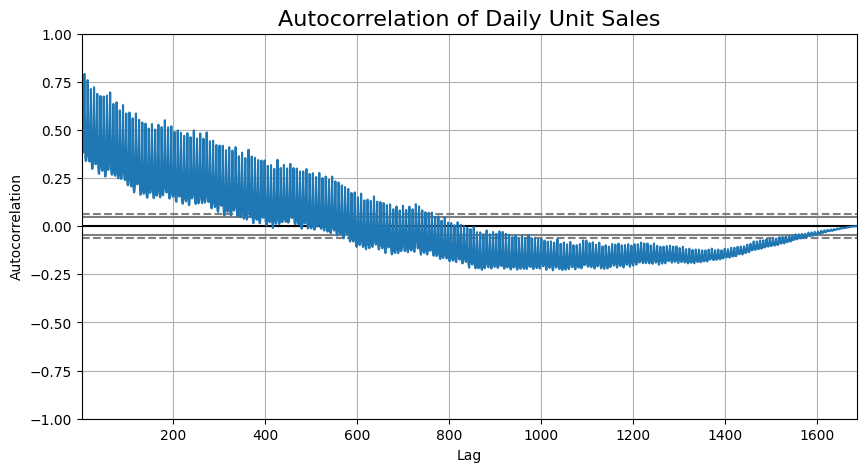

In [ ]:
from pandas.plotting import autocorrelation_plot

# Aggregate total sales per day
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plot autocorrelation
plt.figure(figsize=(10, 5))
autocorrelation_plot(sales_by_date)
plt.title('Autocorrelation of Daily Unit Sales', fontsize=16)
plt.show()


- Interpretation:
Wenn die Autokorrelationskurve auch bei Verzögerungen von 1, 2, 3 usw. hoch bleibt , bedeutet dies, dass vergangene Werte zukünftige Werte stark beeinflussen.
Das bedeutet, dass Verzögerungsmerkmale (wie Verkäufe vor 1 Tag, vor 7 Tagen usw.) Ihrem Modell zu besseren Vorhersagen verhelfen können.

- So interpretieren Sie dieses Diagramm
  - Starke Autokorrelation bei kurzen Verzögerungen (linke Seite) :
Sie können sehen, dass die Balken sehr hoch beginnen (ca. 0,75 ), was bedeutet:
Die heutigen Verkäufe ähneln stark den Verkäufen der letzten Tage.
Das ist sinnvoll, da die Umsätze in Zeitreihen normalerweise eine gewisse Trägheit aufweisen und nicht wild schwanken.
  - Langsamer Zerfall im Laufe der Zeit :
Die Balken werden allmählich kleiner, anstatt sofort abzufallen.
Das sagt uns:
Selbst Verkäufe von vor Hunderten von Tagen haben noch einen gewissen Vorhersagewert, wenn auch in geringerem Maße.
  - Gepunktete Linien = statistische Signifikanz :
Balken über den horizontalen gestrichelten Linien bedeuten, dass diese Verzögerungen statistisch signifikant sind.
Wie Sie sehen, liegen viele der frühen Verzögerungen deutlich über der Grenze – insbesondere in den ersten ~300 Tagen.

- Verzögerungsmerkmale (wie unit_salesvor 1, 7 oder 30 Tagen) sind für die Vorhersage sehr nützlich .
- Zeitreihenmodelle (wie XGBoost, LightGBM, LSTM oder ARIMA) profitieren von der Einbeziehung historischer Verkaufsdaten als Eingabe.

# Abschluss:
✔️ Ihre täglichen Verkaufsdaten weisen eine hohe Autokorrelation auf, insbesondere kurzfristig. Das sind großartige Neuigkeiten – es bedeutet, dass die Vergangenheit prädiktiv ist und Sie mithilfe von verzögerungsbasierten Funktionen leistungsstarke Modelle erstellen können.

# (Erweiterte) Schlüsselmerkmale von Zeitreihendaten: Stationarität

Stationarität bedeutet, dass sich Mittelwert , Varianz und Saisonalität Ihrer Zeitreihe im Laufe der Zeit nicht ändern .

- Test auf Stationarität: visuelle Kontrollen

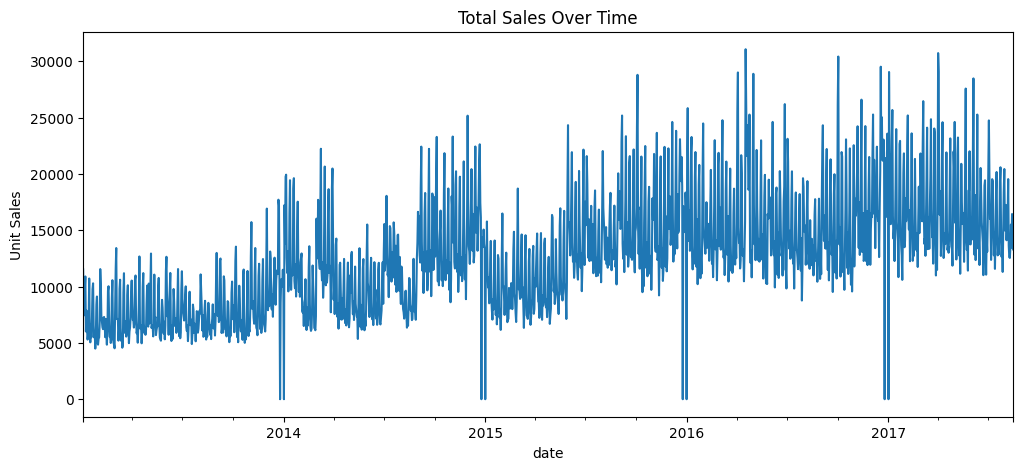

In [ ]:
sales_by_date.plot(figsize=(12,5), title='Total Sales Over Time')
plt.ylabel('Unit Sales')
plt.show()


- Erkennen Sie einen Trend , saisonale Zyklen oder eine zunehmende Varianz ? Wenn ja, ist die Reihe wahrscheinlich nicht stationär.
Unsere Analyse
- Dieses Diagramm des Gesamtumsatzes im Zeitverlauf zeigt deutlich:
Trend : Es ist ein Aufwärtstrend erkennbar – die Umsätze steigen im Laufe der Zeit generell an.
- Saisonalität : Es gibt regelmäßige Zyklen (Spitzen und Einbrüche), die auf saisonale Muster schließen lassen.
Zunehmende Varianz : Die Schwankungen (Höhe der Spitzen) werden mit der Zeit größer.

  - Fazit: Die Daten sind nicht stationär .
Da sich Trend, Saisonalität und Varianz im Laufe der Zeit ändern , bezeichnen wir diese Zeitreihe als nicht stationär .
Dies ist bei Verkaufsdaten üblich und wichtig, da viele Prognosemodelle stationäre Eingaben erfordern (z. B. ARIMA).

- Visuelle Kontrolle: gleitender Mittelwert und Standardabweichung

  - Gleitender Mittelwert → Hilft bei der Erkennung von Trends (d. h. sich im Laufe der Zeit ändernder Durchschnitt)
  - Rollierender Standardwert → Hilft bei der Identifizierung sich ändernder Varianzen (ein Hinweis auf Heteroskedastizität oder Nichtstationarität)

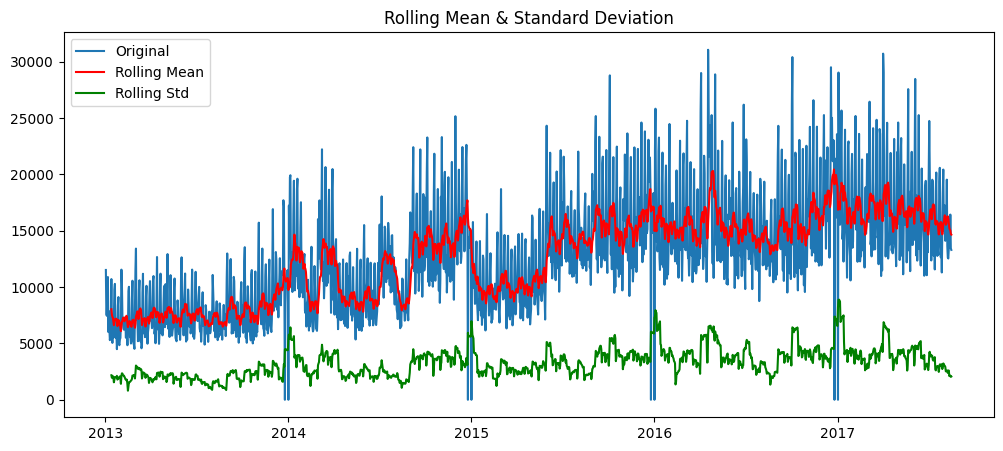

In [ ]:
rolling_mean = sales_by_date.rolling(window=12).mean()
rolling_std = sales_by_date.rolling(window=12).std()

plt.figure(figsize=(12,5))
plt.plot(sales_by_date, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

- Interpretation des Diagramms mit gleitendem Mittelwert und Standardabweichung:
Wenn sowohl der gleitende Mittelwert als auch die Standardabweichung annähernd horizontal und stabil sind , handelt es sich bei der Reihe wahrscheinlich um eine stationäre Reihe .
Wenn sich entweder der Mittelwert oder die Varianz im Laufe der Zeit ändert , ist dies nicht stationär .

- Erkennen Sie Muster oder Zyklen in den Daten?
- Scheint das Durchschnittsniveau der Serie im Laufe der Zeit konstant zu sein?
- Wie steht es um die Spanne – werden die Höhen und Tiefen extremer?
- Würden Sie aufgrund Ihrer Beobachtungen sagen, dass diese Daten stationär sind?

- 📈 Originalserie (blaue Linie)
Zeigt eine hohe Volatilität und deutliche saisonale Spitzen – wahrscheinlich wöchentliche oder monatliche Zyklen.
Auch in den ersten Jahren, insbesondere von 2013 bis 2015, ist ein Aufwärtstrend erkennbar .
Spitzen und Einbrüche weisen auf Feiertagseffekte , Anomalien oder Nachfragespitzen hin.
Visuelle Spitzen in den Rohdaten (blaue Linie) können den Anschein einer zunehmenden Varianz erwecken – insbesondere, weil die Spitzen in späteren Jahren höher erscheinen.
- 📉 Gleitender Mittelwert (rote Linie)
Nimmt im Laufe der Zeit bis ~2015 deutlich zu und flacht dann ab – dies bestätigt einen nichtstationären Mittelwert (d. h. der Durchschnitt ändert sich im Laufe der Zeit).
Deutet auf das Vorhandensein eines Trends im frühen Teil der Serie hin.
- 📊 Rollierende Standardabweichung (grüne Linie)
Einige Schwankungen im Laufe der Zeit , aber im Allgemeinen stabiler als der Mittelwert.
Einige wenige auffällige Spitzen können auf die Ferienzeit oder Sonderangebote zurückzuführen sein .
Würde die Varianz im Laufe der Zeit deutlich zunehmen, würde dies auf Heteroskedastizität hindeuten , hier scheint sie jedoch ziemlich stabil zu sein, was darauf schließen lässt, dass die Varianzstationarität kein großes Problem darstellt.
Die gleitende Standardabweichung (grüne Linie) – ein zuverlässigerer Indikator als die ursprüngliche Reihe – zeigt keinen starken Aufwärtstrend in der Varianz.

✅ Fazit:
Aufgrund sichtbarer Trends und Saisonalität ist die Reihe im Mittel nicht stationär .
Die Varianz scheint größtenteils stabil zu sein , obwohl ein formaler Test (wie wir später sehen werden, z. B. Log-Transformation, Box-Cox) dies bestätigen könnte.

- Test auf Stationarität: Statistischer Test Augmented Dickey-Fuller (ADF)

Der ADF-Test prüft, ob eine Einheitswurzel vorhanden ist , die darauf hinweisen würde, dass die Reihe nicht stationär ist .
 - Nullhypothese (H₀): Die Reihe hat eine Einheitswurzel → nicht stationär
 - Alternativhypothese (H₁): Die Reihe ist stationär.
2. Ergebnisinterpretation:
 - Wenn der p-Wert < 0,05 ist , ist die Reihe stationär (gut für die Modellierung).
 - Wenn der p-Wert > 0,05 ist , ist die Reihe nicht stationär – und das ist wichtig, weil viele Prognosemodelle stationäre Eingaben erfordern (z. B. ARIMA).

In [ ]:
import pandas as pd
!pip install statsmodels

from statsmodels.tsa.stattools import adfuller

# Diese Spalte enthält den täglichen Gesamtumsatz.
sales_by_date = df_merged_daily['unit_sales'].dropna()

print("--- ADF-Test zur Überprüfung der Stationarität ---")

# Durchführung des ADF-Tests
result = adfuller(sales_by_date)

print(f"Zeitreihe: Daily Total Unit Sales (Anzahl der Datenpunkte: {len(sales_by_date)})")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("---")
print("Kritische Werte:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

# Interpretation des p-Wertes
if result[1] <= 0.05:
    print("\nERGEBNIS: Der p-Wert ist <= 0.05. Die Nullhypothese wird verworfen. Die Zeitreihe ist wahrscheinlich **stationär**.")
else:
    print("\nERGEBNIS: Der p-Wert ist > 0.05. Die Nullhypothese kann nicht verworfen werden. Die Zeitreihe ist wahrscheinlich **nicht-stationär** (d.h. sie hat einen Trend oder Saisonalität).")

# Optional: Um die Interpretation zu vereinfachen, können Sie auch den T-Wert mit dem kritischen Wert vergleichen.
# Wenn ADF Statistic < Kritischer Wert (z.B. bei 5%), wird die Nullhypothese verworfen (stationär).


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 1.0 MB/s eta 0:00:00
--- ADF-Test zur Überprüfung der Stationarität ---
Zeitreihe: Daily Total Unit Sales (Anzahl der Datenpunkte: 1687)
ADF Statistic: -2.813483627524129
p-value: 0.05637339115822938
---
Kritische Werte:
	1%: -3.4342859473725906
	5%: -2.8632784969542016
	10%: -2.56769553371452

ERGEBNIS: Der p-Wert ist > 0.05. Die Nullhypothese kann nicht verworfen werden. Die Zeitreihe ist wahrscheinlich **nicht-stationär** (d.h. sie hat einen Trend oder Saisonalität).


- Interpretation:
Ein üblicher Schwellenwert für den p-Wert ist 0,05 .
Da 0.056 > 0.05können wir die Nullhypothese nicht ablehnen .
Das bedeutet, dass die Beweislage nicht ausreicht, um von einer Stationärität der Reihe zu sprechen.

- Abschluss:
Die Zeitreihe ist wahrscheinlich nicht stationär.
Dies bestätigt, was wir bereits visuell beobachtet haben:
Ein Aufwärtstrend
Zunehmende Varianz
Saisonale Zyklen

- Diagnose von Trends und Saisonalität

- Visuelle Zerlegung :
Verwenden Sie STLoder , seasonal_decompose()um die Serie aufzuteilen in:
  - Beobachtet (Originalreihe) : Dies hilft Ihnen, ein Gefühl dafür zu bekommen, was die Form der Daten beeinflussen könnte.
  - Trend (langfristige Richtung): Wenn diese Linie im Laufe der Zeit zunimmt oder abnimmt, weisen Ihre Daten einen Trend auf, der zu Nichtstationarität führt. Eine flache Trendlinie deutet darauf hin, dass die Reihe im Mittel stationär ist.
  - Saisonal (wiederkehrende Muster): Eine starke, regelmäßige Welle in diesem Bereich weist auf Saisonalität hin. Bei gleichbleibender Amplitude der Welle ist die Saisonalität stabil; andernfalls kann sie im Laufe der Zeit variieren.
  - Rest (was übrig bleibt): Sollte weißem Rauschen ähneln (zufälliges Rauschen ohne Muster).

- STL-Zerlegung (robuster und empfohlen)


--- Start der STL Decomposition ---


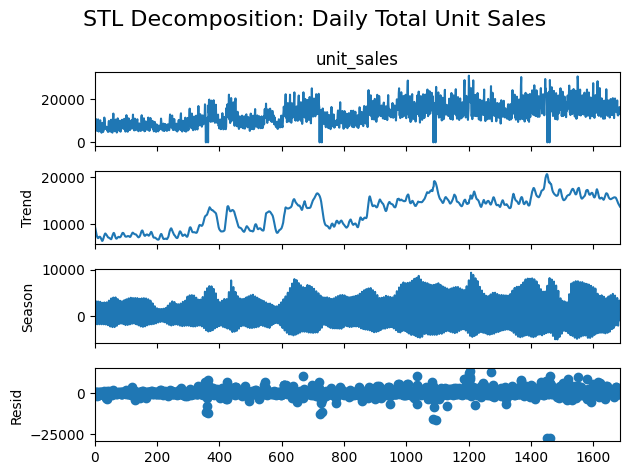

STL Decomposition erfolgreich durchgeführt.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install statsmodels

from statsmodels.tsa.stattools import adfuller
print("\n--- Start der STL Decomposition ---")

# STL decomposition
# 'period=7' wird verwendet, da die Umsatzdaten typischerweise eine wöchentliche Saisonalität aufweisen (7 Tage).
try:
    from statsmodels.tsa.seasonal import STL

    stl = STL(sales_by_date, period=7, robust=True)
    res = stl.fit()

    # Plot STL decomposition
    res.plot()
    plt.suptitle("STL Decomposition: Daily Total Unit Sales", fontsize=16)
    plt.tight_layout()
    plt.show()
    print("STL Decomposition erfolgreich durchgeführt.")

except Exception as e:
    print(f"Fehler bei der STL Decomposition: {e}")
    print("Stellen Sie sicher, dass die Zeitreihe keine NaN-Werte enthält und dass der Index sortiert ist.")


- Messen Sie die Stärke von Trends und Saisonalität :
  - Verwenden Sie die Dekompositionsausgabe, um zu quantifizieren, wie dominant Trend- und Saisonkomponenten sind.
  - Auf diese Weise können Sie leichter entscheiden, ob Sie sie vor dem Modellieren entfernen oder anpassen müssen.

- Dies sind sehr hohe Werte (nahe 1,0), was bedeutet:
Der Trend ist dominant – er erklärt die meisten Abweichungen in den Daten.
Auch die Saisonalität ist stark ausgeprägt und spielt eine wichtige Rolle bei der Gestaltung der Serie.
Ihre Daten sind also aufgrund von Trends und Saisonalität stark nichtstationär .

!!! Was Sie mit diesen Erkenntnissen tun können: Um Ihre Daten für Modelle wie ARIMA geeignet zu machen , müssen Sie wahrscheinlich den Trend und die Saisonalität entfernen. Sie können Trend und Saisonalität auch einzeln prognostizieren und diese dann zu einer vollständigen Prognose neu kombinieren.

# Zusammenfassung der Daten dieses Anwendungsfalls


- Konzept
  - Warum es wichtig ist
    - Was wir gelernt haben
- Autokorrelation
  - Hilft, Abhängigkeiten rechtzeitig zu erkennen
    - Ja, die heutigen Verkäufe spiegeln die vorherigen Tage wider – Verzögerungsfunktionen sind nützlich
- Stationarität
  - Für einige Modelle wie ARIMA erforderlich
    - Nicht stationär